In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from warnings import filterwarnings

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetV2S, MobileNetV3Large

from src.training_evaluation import IMG_SIZE, INITIAL_EPOCHS, test_models, build_model_for_fine_tuning, fine_tune_models
from src.data_preprocessing import augment_function
from src.data_visuals import show_saved_fig
from src.use_model import make_prediction

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

tf.get_logger().setLevel('ERROR')
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('history', exist_ok=True)
filterwarnings('ignore', category=UserWarning)

print(tf.__version__)
tf.config.list_physical_devices("GPU")

2.18.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data

As the test set is quite large, some of the data from the training and test sets were separated into the validation set and merged together to form this third set and obtain a ratio of approximately 70:10:20.

In [3]:
load_dataset_kwargs = {
    "image_size": (IMG_SIZE, IMG_SIZE),
    "label_mode": "int",
    "batch_size": 32,
    "seed": 42,
    "subset": "both",
    "verbose": False
}

train_data, validation_data_1 = image_dataset_from_directory("food101_train",
                                                              validation_split=0.05,
                                                             **load_dataset_kwargs
                                                              )

test_data, validation_data_2 = image_dataset_from_directory("food101_test",
                                                             validation_split=0.2,
                                                             **load_dataset_kwargs
                                                            )

validation_data = validation_data_1.concatenate(validation_data_2)

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE)

Using 71104 files for training.
Using 3742 files for validation.
Using 20205 files for training.
Using 5051 files for validation.


# Feature extraction model

In [8]:
# `EfficientNetV2S` and `ConvNextTiny` do not require an additional function for preprocessing, which is included in the models.

models_config = [
    {
        'model': applications.MobileNetV3Large,
        'preprocessor': applications.mobilenet_v3.preprocess_input
    },
    {
        'model': applications.EfficientNetV2S,
        'preprocessor': None
    },
    {
        'model': applications.Xception,
        'preprocessor': applications.xception.preprocess_input,
    },
    {
        'model': applications.ConvNeXtTiny,
        'preprocessor': None,
    },
    {
        'model': applications.ResNet50V2,
        'preprocessor': applications.resnet_v2.preprocess_input,
    }
]

# results_df = test_models(models_config, train_data, validation_data, test_data)
results_df = pd.read_csv("feature_extraction_results.csv")
results_df.sort_values(by="Test accuracy", ascending=False).round(2)

,Model,Base model params,Validation accuracy,Test accuracy
1,EfficientNetV2S,20331360,0.66,0.72
3,ConvNeXtTiny,27820128,0.65,0.71
0,MobileNetV3Large,2996352,0.67,0.70
2,Xception,20861480,0.56,0.60
4,ResNet50V2,23564800,0.55,0.58


The `EfficientNetV2S` model was chosen for further testing, but as the much smaller `MobileNetV3Large` model gave similar results, it seems interesting to try fine tuning it too.

# Fine tuning

With mixed precision, to reduce memory usage and speed up computation, and `LossScaleOptimizer` to avoid problems with too small values.

Model checkpointing was used to save the best weights, along with learning rate reduction on plateau and early stopping to speed up training and prevent overfitting.

Experiments were carried out with different learning rates and different numbers of unfrozen model layers. Only some of the results are shown below.

## Initial

In [9]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [31]:
initial_ft_results = fine_tune_models("initial_fine_tuning", train_data, learning_rate=5e-05,
                                       add_epochs=42, initial_epoch=INITIAL_EPOCHS)
# initial_ft_results = pd.read_csv("initial_fine_tuning_results.csv").round(3)
initial_ft_results

,Model,Validation Accuracy,Test Accuracy
0,EfficientNetV2S,0.765,0.784
1,MobileNetV3Large,0.727,0.746


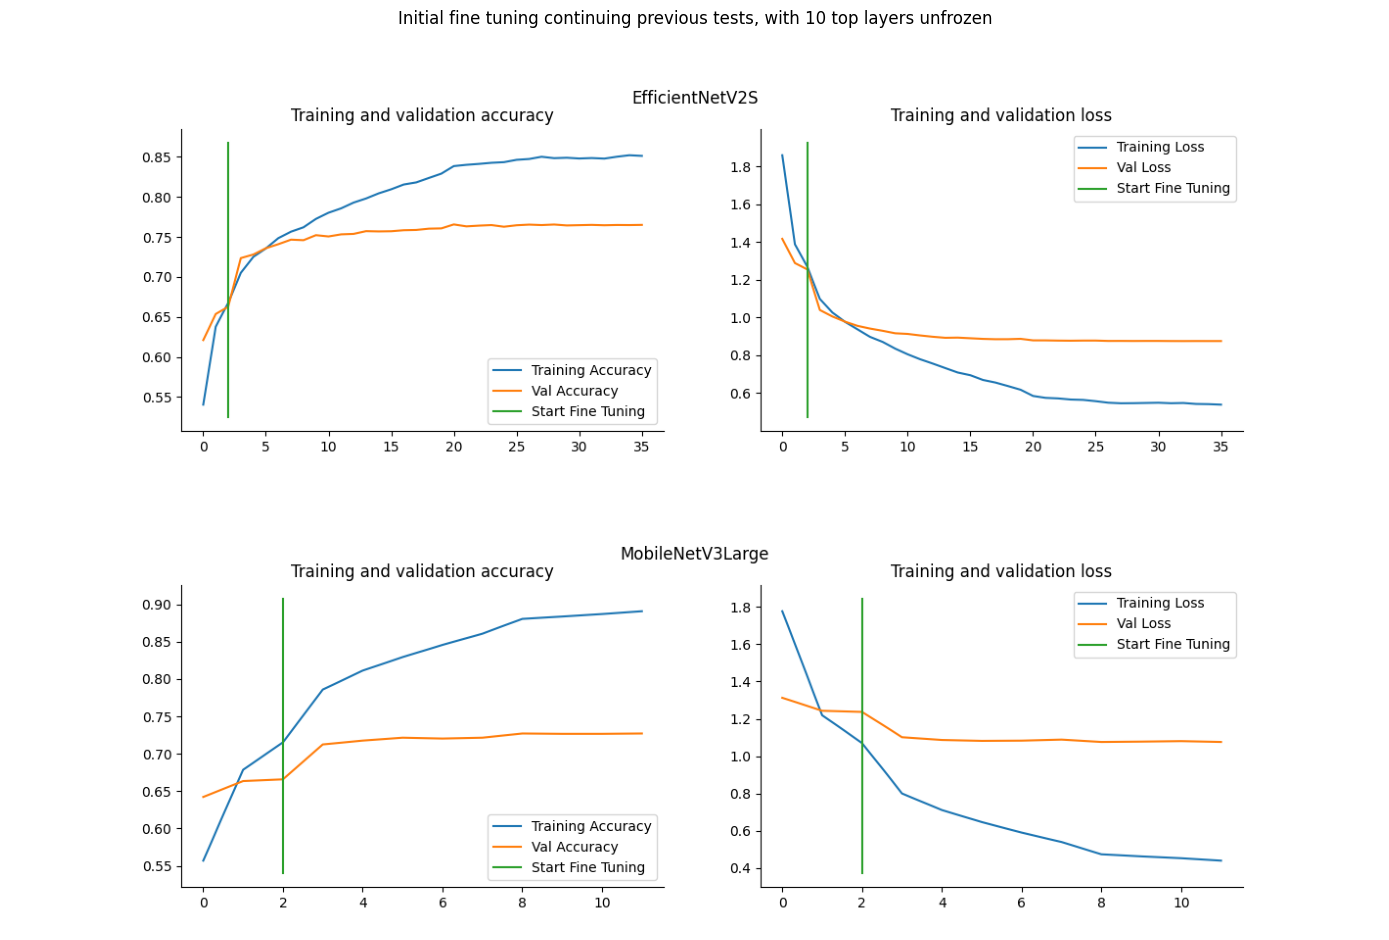

In [10]:
show_saved_fig(
    ["images/EfficientNetV2S_initial_fine_tuning.png",
     "images/MobileNetV3Large_initial_fine_tuning.png"],
    suptitle="Initial fine tuning continuing previous tests, with 10 top layers unfrozen"
)

## Fine tuning with data augmentation

With multi-thread preprocessing for data augmenation, since the models proved to be prone to overfitting.

The images were augmented using random rotation, cropping, resizing, horizontal flipping, brightness adjustment and contrast adjustment. \
Overfitting was successfully reduced, which was also helped by reducing the `learning rate` and adding a `Dropout` layer.

The highest accuracy was achieved with `EfficientNetV2S` unfreezing all layers (except for `BatchNormalizationLayer`).
For `MobileNetV3Large`, proceeded as above and added a `Dense` layer with 1024 units.

In [10]:
train_data_augmented = train_data.map(augment_function, num_parallel_calls=tf.data.AUTOTUNE)
train_data_augmented = train_data_augmented.prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
fine_tune_models("fine_tuning_data_augmentation_1e-05_all", train_data_augmented, validation_data, test_data,
                 model_list=[EfficientNetV2S], learning_rate=1e-05, add_epochs=100, unfrozen_layers=516)
fine_tune_models("fine_tuning_data_augmentation_1e-05_alllayers+Dense1024", train_data_augmented, validation_data, test_data,
                 model_list=[MobileNetV3Large], learning_rate=1e-05, add_epochs=100, unfrozen_layers=190)

all_layers_results = pd.concat([
                            pd.read_csv("fine_tuning_data_augmentation_1e-05_all_results.csv"),
                            pd.read_csv("fine_tuning_data_augmentation_1e-05_alllayers+Dense1024_results.csv")
                        ]).reset_index(drop=True).round(2)
all_layers_results

,Model,Validation Accuracy,Test Accuracy
0,EfficientNetV2S,0.82,0.83
1,MobileNetV3Large,0.72,0.74


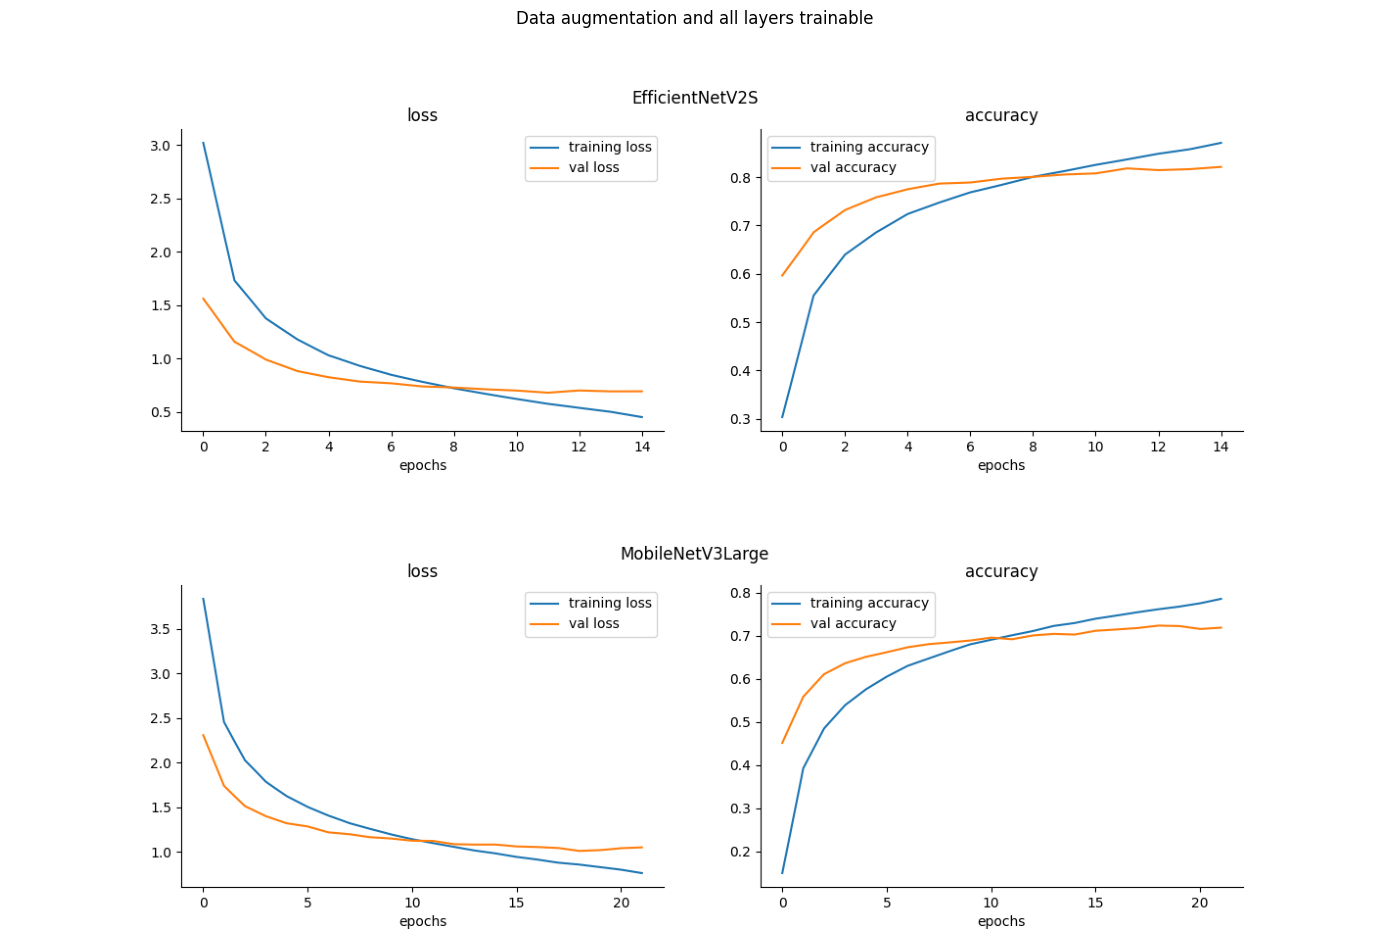

In [120]:
show_saved_fig([
    "images/EfficientNetV2S_fine_tuning_data_augmentation_1e-05_all.png",
    "images/MobileNetV3Large_fine_tuning_data_augmentation_1e-05_alllayers+Dense1024.png"
], suptitle="Data augmentation and all layers trainable")

In [8]:
model = build_model_for_fine_tuning(EfficientNetV2S)
model.load_weights("checkpoints/EfficientNetV2S_fine_tuning_data_augmentation_1e-05_all.keras")
model.compile(loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.evaluate(test_data)

632/632 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.8338 - loss: 0.5840


[0.5926881432533264, 0.8346943855285645]

In [10]:
model.save("fine_tuned_model.keras", include_optimizer=False)

# Predicting external images class

In [29]:
model = tf.keras.models.load_model("fine_tuned_model.keras")
model.evaluate(test_data)

632/632 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.8338 - loss: 0.5823


[0.5926877856254578, 0.8346943855285645]

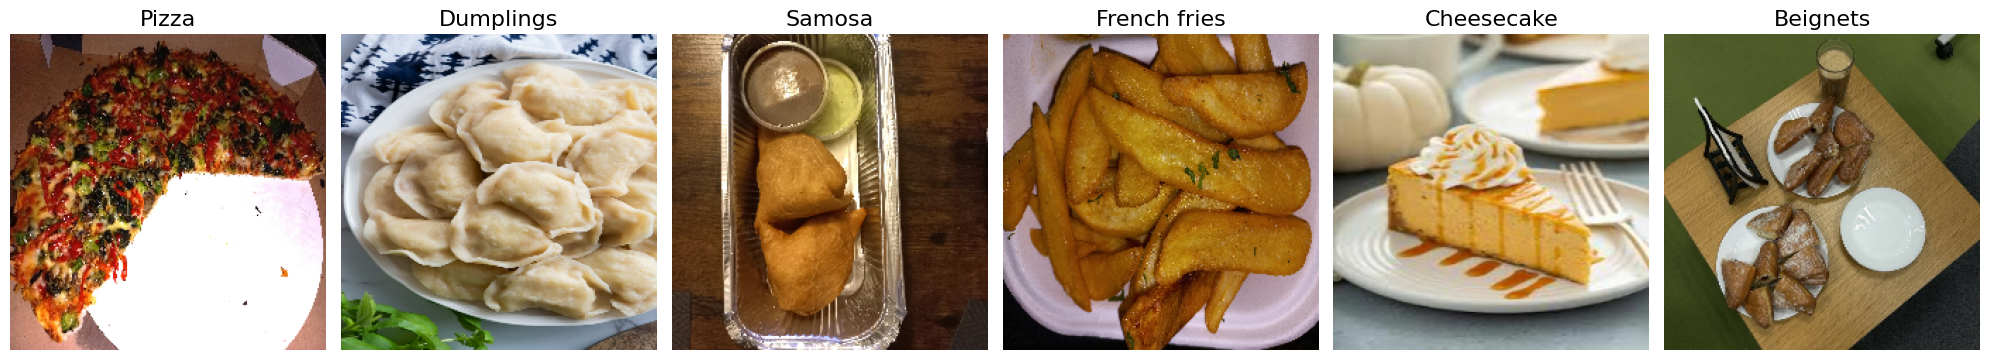

In [18]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
for i, path in enumerate([img for img in os.listdir("images/test") if ".ipynb_checkpoints" not in img]):
    path = f"images/test/{path}"
    make_prediction(path, model, ax=ax[i])
plt.tight_layout()
plt.show()

### Unfortunately, the model struggles with recognizing food-shaped plush toys :)

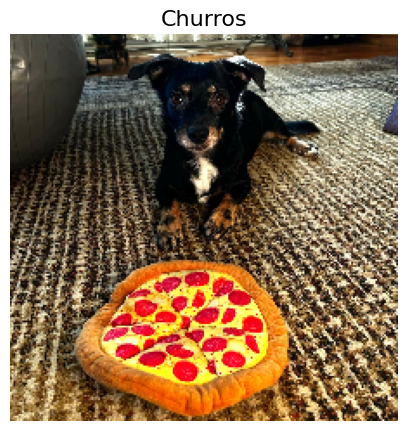

In [28]:
fig, ax = plt.subplots(figsize=(5, 6))
make_prediction("images/test/pizza_lola.jpeg", model=model, ax=ax)
plt.show()